Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [33]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [34]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [35]:
import numpy as np

def wrangle(X):
    X = X.copy()
    
    #convert date to datetime object
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format = True)
    
    #Break the date out into its component features
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns = 'date_recorded')
    
    #I kinda want to see if imputing this engineered feature helps some.
    X['years'] = X['year_recorded'] - X['construction_year']#.replace(0, X['construction_year'].mean())
    
    #Changes to much, or not at all
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns = unusable_variance)
    
    #Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns = duplicate_columns)
    
    #latitude has some near zero values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    #columns with zeros need to be replaced with nans
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X

In [36]:
#Just focused on delivering MVP tonight.  Any extra time will be spent on a new submission.
from sklearn.model_selection import train_test_split
target = 'status_group'

train, val = train_test_split(train, test_size = len(test), stratify = train[target], 
                              random_state = 42)

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [37]:
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test

In [38]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8140409527789386


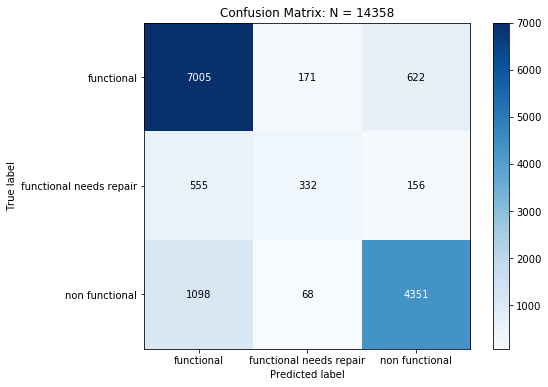

In [39]:
#okay lets just jump to scikitplot, since it is a little nicer looking
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_val, y_pred,
                                   figsize = (8, 6),
                                   title = f'Confusion Matrix: N = {len(y_val)}',
                                   normalize = False);

In [40]:
#accuracy, aka how many correct predictions did we make / total predictions
#add up the nw->se diagonl, divide it by our validation length

accuracy = (7005 + 332 + 4351) / len(y_val)
print('Accuracy is: ', accuracy)

Accuracy is:  0.8140409527789386


In [41]:
#Precision is the number of correct predictions we are trying to predict for (functionality) /
#the total predictions of that class.  Done by dividing NW corner by the entire west column
precision = 7005 / (7005 + 555 + 1098)
print('Precision is: ', precision)

Precision is:  0.8090783090783091


In [42]:
#lets do it easier
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.58      0.32      0.41      1043
         non functional       0.85      0.79      0.82      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.67      0.69     14358
           weighted avg       0.81      0.81      0.81     14358

